In [43]:
import torch
from torch import nn

print(torch.__version__)

2.0.1


In [44]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cpu


### 1. Get data

In [45]:
import requests 
import zipfile
from pathlib import Path

data_path = Path("data")
image_path = data_path / "pizza_steak_sushi"

image_path.mkdir(parents=True, exist_ok=True)

with open(data_path/ "pizza_steak_sushi.zip", "wb") as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
    f.write(request.content)

with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
    zip_ref.extractall(image_path)

### 2. Data preparation

In [46]:
import os
for dirpath, dirname, filename in os.walk(image_path):
    print(f"There are {len(dirname)} directories and {len(filename)} files in {dirpath}")

There are 2 directories and 0 files in data/pizza_steak_sushi
There are 3 directories and 0 files in data/pizza_steak_sushi/test
There are 0 directories and 19 files in data/pizza_steak_sushi/test/steak
There are 0 directories and 31 files in data/pizza_steak_sushi/test/sushi
There are 0 directories and 25 files in data/pizza_steak_sushi/test/pizza
There are 3 directories and 0 files in data/pizza_steak_sushi/train
There are 0 directories and 75 files in data/pizza_steak_sushi/train/steak
There are 0 directories and 72 files in data/pizza_steak_sushi/train/sushi
There are 0 directories and 78 files in data/pizza_steak_sushi/train/pizza


In [47]:
train_dir = image_path / "train"
test_dir = image_path / "test"

print(train_dir, test_dir)

data/pizza_steak_sushi/train data/pizza_steak_sushi/test


Random image path: data/pizza_steak_sushi/test/pizza/2236338.jpg
Image class: pizza
Image height: 512, width: 512
Image size: (512, 512)


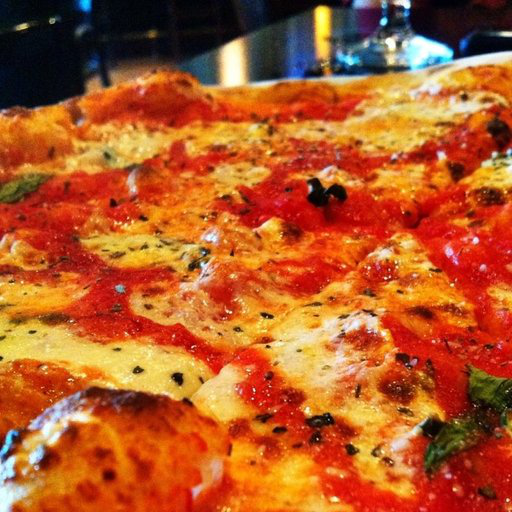

In [48]:
# visualizing an image

import random
from PIL import Image

random.seed(42)

image_path_list = list(image_path.glob("*/*/*.jpg"))
random_image_path = random.choice(image_path_list)
image_class = random_image_path.parent.stem

img = Image.open(random_image_path)

print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}, width: {img.width}")
print(f"Image size: {img.size}")
img

(-0.5, 511.5, 511.5, -0.5)

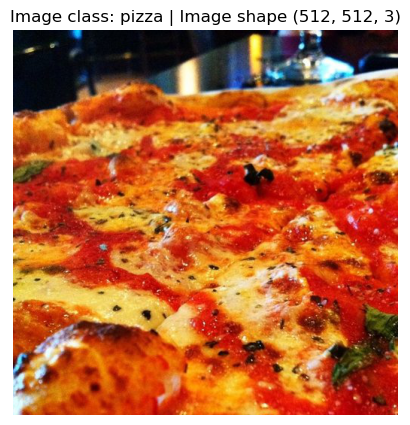

In [49]:
import numpy as np
import matplotlib.pyplot as plt

img_array = np.array(img)

plt.figure(figsize=(5, 5))
plt.imshow(img_array)
plt.title(f"Image class: {image_class} | Image shape {img_array.shape}")
plt.axis(False)

### 3. Data transforms

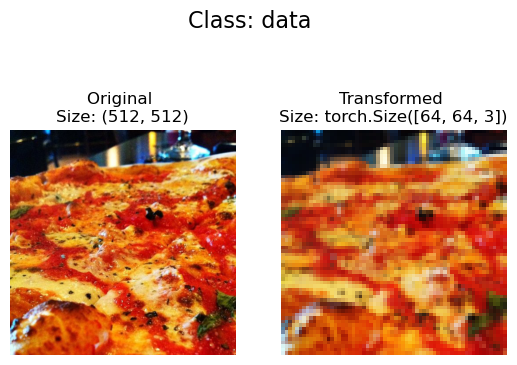

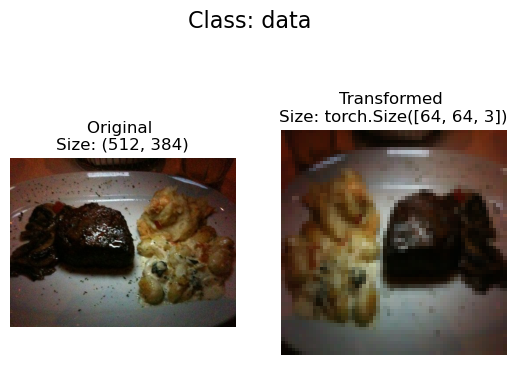

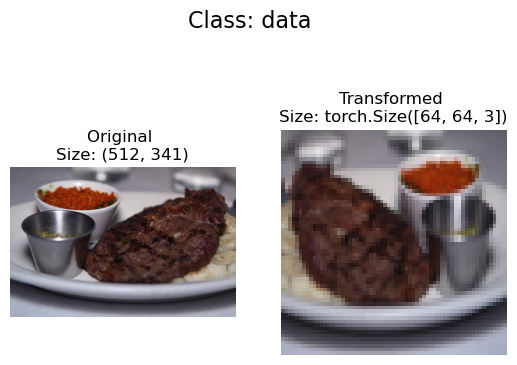

In [50]:
import torch
from torchvision import transforms, datasets
from torch.utils.data import DataLoader

data_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

def plot_transformed_image(image_paths, transform, n=3, seed=42):
    random.seed(42)
    random_image_path = random.sample(image_paths, k=n)
    for img_path in random_image_path:
        with Image.open(img_path) as f:
            fig, axs = plt.subplots(1, 2)
            axs[0].imshow(f)
            axs[0].set_title(f"Original \nSize: {f.size}")
            axs[0].axis(False)

            transformed_img = transform(f).permute(1, 2, 0)
            # Pytorch default is [C, H, W], but matplotlib is [H, W, C]
            axs[1].imshow(transformed_img)
            axs[1].set_title(f"Transformed \nSize: {transformed_img.shape}")
            axs[1].axis(False)

            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_image(image_paths=image_path_list, transform=data_transform)


### 4. Option1: Loading image data using `torchvision.datasets.ImageFolder`

In [51]:
from torchvision.datasets import ImageFolder

train_data = ImageFolder(root=train_dir,
                         transform=data_transform)

test_data = ImageFolder(root=test_dir,
                        transform=data_transform)

print(f"Train data: \n{train_data}\nTest data: \n{test_data}")

class_names = train_data.classes
class_dict = train_data.class_to_idx
print(f"class name: {class_names} | class dict: {class_dict}\ntrain data length: {len(train_data)} | test data length: {len(test_data)}")

Train data: 
Dataset ImageFolder
    Number of datapoints: 225
    Root location: data/pizza_steak_sushi/train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )
Test data: 
Dataset ImageFolder
    Number of datapoints: 75
    Root location: data/pizza_steak_sushi/test
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )
class name: ['pizza', 'steak', 'sushi'] | class dict: {'pizza': 0, 'steak': 1, 'sushi': 2}
train data length: 225 | test data length: 75


In [52]:
img, label  = train_data[0]
print(f"Image shape: {img.shape} | Image datatype: {img.dtype}\nlabel: {label} | label datatye: {type(label)} ")

Image shape: torch.Size([3, 64, 64]) | Image datatype: torch.float32
label: 0 | label datatye: <class 'int'> 


In [53]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_data,
                              batch_size=1,
                              num_workers=1,
                              shuffle=True)

test_dataloader = DataLoader(test_data,
                             batch_size=1,
                             num_workers=1,
                             shuffle=False)

img, label = next(iter(train_dataloader))
print(f"Image shape: {img.shape} | Label shape: {label.shape} ")

Image shape: torch.Size([1, 3, 64, 64]) | Label shape: torch.Size([1]) 


### 5. Option2: Loading image data with custom `Dataset`

In [54]:
import os
from pathlib import Path
from PIL import Image
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms

##### 5.1. Creating function to get class names

In [55]:
class_name_found  = sorted([entry.name for entry in os.scandir(train_dir)])
print(class_name_found)

['pizza', 'steak', 'sushi']


In [56]:
def find_class(dir_path):
    classes = sorted([entry.name for entry in os.scandir(dir_path)])
    class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
    return classes, class_to_idx

In [57]:
classes, class_to_idx = find_class(train_dir)
print(classes, class_to_idx)

['pizza', 'steak', 'sushi'] {'pizza': 0, 'steak': 1, 'sushi': 2}


##### 5.2. Create custom `Dataset`

In [58]:
from torch.utils.data import Dataset

class Custom_dataset(Dataset):
    def __init__(self, target_dir, transform=None):
        self.paths = list(Path(target_dir).glob("*/*.jpg"))
        self.transform = transform
        self.classes, self.class_to_idx = find_class(target_dir)

    def load_image(self, index):
        image_path = self.paths[index]
        return Image.open(image_path)
    
    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, index):
        img = self.load_image(index)
        class_name = self.paths[index].parent.stem
        class_idx = self.class_to_idx[class_name]

        if self.transform:
            return self.transform(img), class_idx
        else:
            return img, class_idx

In [59]:
train_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

test_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

In [60]:
train_custom_dataset = Custom_dataset(train_dir,
                                      train_transforms)
test_custom_dataset = Custom_dataset(test_dir,
                                     test_transforms)
print(len(train_custom_dataset), len(test_custom_dataset))
print(train_custom_dataset[0])

225 75
(tensor([[[0.1255, 0.1333, 0.1294,  ..., 0.9020, 0.8980, 0.8863],
         [0.1961, 0.2039, 0.2039,  ..., 0.9098, 0.9020, 0.8941],
         [0.2627, 0.2667, 0.2902,  ..., 0.9059, 0.9020, 0.8980],
         ...,
         [0.0510, 0.0588, 0.0824,  ..., 0.4353, 0.4431, 0.4471],
         [0.0431, 0.0353, 0.0431,  ..., 0.4314, 0.4275, 0.4314],
         [0.1529, 0.0784, 0.0431,  ..., 0.4196, 0.4196, 0.4314]],

        [[0.0824, 0.0902, 0.0863,  ..., 0.9176, 0.9137, 0.8980],
         [0.1216, 0.1333, 0.1294,  ..., 0.9255, 0.9176, 0.9059],
         [0.1686, 0.1765, 0.1961,  ..., 0.9216, 0.9176, 0.9098],
         ...,
         [0.0510, 0.0588, 0.0863,  ..., 0.3373, 0.3412, 0.3333],
         [0.0471, 0.0431, 0.0431,  ..., 0.3333, 0.3294, 0.3216],
         [0.1216, 0.0706, 0.0431,  ..., 0.3294, 0.3255, 0.3137]],

        [[0.0431, 0.0510, 0.0510,  ..., 0.8588, 0.8510, 0.8314],
         [0.0745, 0.0824, 0.0824,  ..., 0.8667, 0.8588, 0.8353],
         [0.1137, 0.1059, 0.1255,  ..., 0.8667, 0.

##### 5.3. Create function display random images

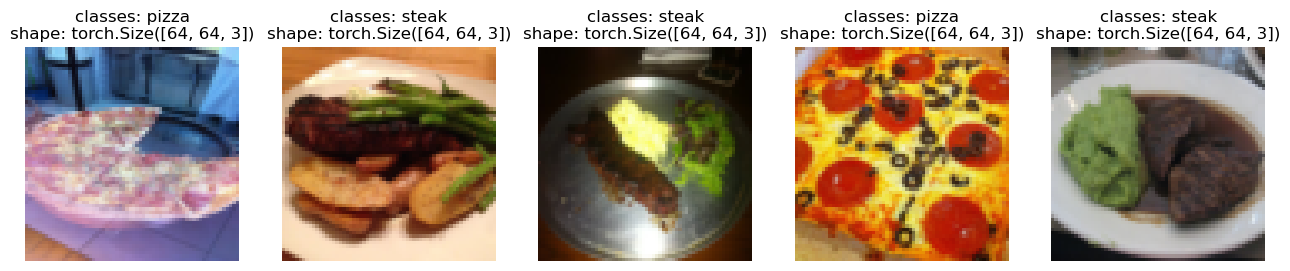

In [61]:
def display_random_images(datasets, classes, display_shape=True, n=10, seed=None):
    if n > 10:
        n=10
        display_shape = False

    if seed:
        random.seed(seed)
    
    random_sample_idx = random.sample(range(len(datasets)), k=n)
    _, axs = plt.subplots(1, n, figsize=(16, 8))

    for i, target_idx in enumerate(random_sample_idx):
        img, label = datasets[target_idx]
        axs[i].imshow(img.permute(1, 2, 0))
        axs[i].axis(False)
        if classes:
            title = f"classes: {classes[label]}"
            if display_shape:
                axs[i].set_title(title + f"\nshape: {img.permute(1, 2, 0).shape}")
            else:
                axs[i].set_title(title)

display_random_images(train_custom_dataset, classes, n=5, seed=42)

##### 5.4 Turn custom `Dataset` to `DataLoader`

In [62]:
from torch.utils.data import DataLoader

train_custom_dataloader = DataLoader(dataset=train_custom_dataset,
                                     batch_size=32,
                                     shuffle=True)
test_custom_dataloader = DataLoader(dataset=test_custom_dataset,
                                    batch_size=32,
                                    shuffle=False)

train_custom_dataloader, test_custom_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x1565bb460>,
 <torch.utils.data.dataloader.DataLoader at 0x1565bb9d0>)

### 6. Model: TinyVGG without data augmentation

In [63]:
img, label = train_custom_dataset[0]
print(img.shape)
C, H, W = img.shape
print(C, H, W)
class TinyVGG(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(in_channels=input_dim,
                      out_channels=hidden_dim,
                      kernel_size=3,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_dim,
                      out_channels=hidden_dim,
                      kernel_size=3,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_dim,
                      out_channels=hidden_dim,
                      kernel_size=3,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_dim,
                      out_channels=hidden_dim,
                      kernel_size=3,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classification_head = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=int(H/4*W/4*hidden_dim),
                      out_features=output_dim)
        )

    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.classification_head(x)
        return x
    
torch.manual_seed(42)
model = TinyVGG(input_dim=3,
                hidden_dim=10,
                output_dim=len(train_custom_dataset.classes)).to(device)
model

torch.Size([3, 64, 64])
3 64 64


TinyVGG(
  (conv_block1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classification_head): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=3, bias=True)
  )
)

##### 6.1. Try forward path on single image

In [64]:
img_batch, label_batch = next(iter(train_custom_dataloader))

img_single, label_single = img_batch[0].unsqueeze(dim=0), label_batch[0]
model.eval()
with torch.inference_mode():
    pred = model(img_single.to(device))

print(f"Output logits: {pred}\nOutput probilities: {pred.softmax(dim=-1)}\nOutput label: {pred.argmax(dim=-1)}")
print(f"Truth label: {label_single}")

Output logits: tensor([[0.0631, 0.0595, 0.0372]])
Output probilities: tensor([[0.3366, 0.3354, 0.3280]])
Output label: tensor([0])
Truth label: 0


##### 6.2. Use `torchinfo` to get an idea of the shapes going through the model

In [65]:
from torchinfo import summary

summary(model, input_size=(1000, 3, 64, 64 ))

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1000, 3]                 --
├─Sequential: 1-1                        [1000, 10, 32, 32]        --
│    └─Conv2d: 2-1                       [1000, 10, 64, 64]        280
│    └─ReLU: 2-2                         [1000, 10, 64, 64]        --
│    └─Conv2d: 2-3                       [1000, 10, 64, 64]        910
│    └─ReLU: 2-4                         [1000, 10, 64, 64]        --
│    └─MaxPool2d: 2-5                    [1000, 10, 32, 32]        --
├─Sequential: 1-2                        [1000, 10, 16, 16]        --
│    └─Conv2d: 2-6                       [1000, 10, 32, 32]        910
│    └─ReLU: 2-7                         [1000, 10, 32, 32]        --
│    └─Conv2d: 2-8                       [1000, 10, 32, 32]        910
│    └─ReLU: 2-9                         [1000, 10, 32, 32]        --
│    └─MaxPool2d: 2-10                   [1000, 10, 16, 16]        --
├─Sequentia

##### 6.3. Create train & test loop functions

In [66]:
from tqdm import tqdm

def train_step(model, dataloader, loss_fn, optimizer, device):
    train_loss, train_acc = 0, 0
    model.train()
    for X, y in dataloader:
        X, y = X.to(device), y.to(device)
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        y_pred_class = y_pred.argmax(dim=-1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred_class)
    train_loss, train_acc  = train_loss/len(dataloader), train_acc/len(dataloader)
    return train_loss, train_acc

def test_step(model, dataloader, loss_fn, device):
    test_loss, test_acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            loss = loss_fn(y_pred, y)

            test_loss += loss.item()
            y_pred_class = y_pred.argmax(dim=-1)
            test_acc += (y_pred_class==y).sum().item()/len(y_pred_class)
    test_loss, test_acc = test_loss/len(dataloader), test_acc/len(dataloader)
    return test_loss, test_acc

def train(model, train_dataloader, test_dataloader, loss_fn, optimizer, device, epoch_num):
    result = {
        "train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": [],
    }
    for epoch in tqdm(range(epoch_num)):
        print("-"*10 + f"Epoch{epoch}" + "-"*10)
        train_loss, train_acc = train_step(model=model, dataloader=train_dataloader,
                                           loss_fn=loss_fn, optimizer=optimizer,
                                           device=device)
        test_loss, test_acc = test_step(model=model, dataloader=test_dataloader,
                                        loss_fn=loss_fn, device=device)
        print(
            f"train loss: {train_loss:.4f} |"
            f"train accuracy: {train_acc:.4f} |"
            f"test loss: {test_loss:.4f} |"
            f"test accuracy: {test_acc:.4f} |"
        )
        result["train_loss"].append(train_loss.item() if isinstance(train_loss, torch.Tensor) else train_loss)
        result["train_acc"].append(train_acc.item() if isinstance(train_acc, torch.Tensor) else train_acc)
        result["test_loss"].append(test_loss.item() if isinstance(test_loss, torch.Tensor) else test_loss)
        result["test_acc"].append(test_acc.item() if isinstance(test_acc, torch.Tensor) else test_acc)

    return result

##### 6.4. Train and evaluate model

In [82]:
from torch import optim

torch.manual_seed(42)
torch.cuda.manual_seed(42)

EPOCH_NUM = 50
model = TinyVGG(input_dim=3, hidden_dim=10, output_dim=len(train_data.classes)).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(params=model.parameters(),
                      lr=0.001)

model_result = train(model=model,
                     train_dataloader=train_custom_dataloader,
                     test_dataloader=test_custom_dataloader,
                     loss_fn=loss_fn,
                     optimizer=optimizer,
                     device=device,
                     epoch_num=EPOCH_NUM)

  0%|          | 0/50 [00:00<?, ?it/s]

----------Epoch0----------


  2%|▏         | 1/50 [00:01<01:02,  1.28s/it]

train loss: 1.1078 |train accuracy: 0.2539 |test loss: 1.1109 |test accuracy: 0.1979 |
----------Epoch1----------


  4%|▍         | 2/50 [00:02<00:56,  1.17s/it]

train loss: 1.1113 |train accuracy: 0.2695 |test loss: 1.0912 |test accuracy: 0.3229 |
----------Epoch2----------


  6%|▌         | 3/50 [00:03<00:52,  1.12s/it]

train loss: 1.1120 |train accuracy: 0.2852 |test loss: 1.0768 |test accuracy: 0.4792 |
----------Epoch3----------


  8%|▊         | 4/50 [00:04<00:50,  1.10s/it]

train loss: 1.0878 |train accuracy: 0.4258 |test loss: 1.0895 |test accuracy: 0.4896 |
----------Epoch4----------


 10%|█         | 5/50 [00:05<00:50,  1.13s/it]

train loss: 1.0716 |train accuracy: 0.4297 |test loss: 1.0656 |test accuracy: 0.4792 |
----------Epoch5----------


 12%|█▏        | 6/50 [00:06<00:49,  1.12s/it]

train loss: 1.0644 |train accuracy: 0.4258 |test loss: 1.0511 |test accuracy: 0.4896 |
----------Epoch6----------


 14%|█▍        | 7/50 [00:07<00:47,  1.12s/it]

train loss: 1.0448 |train accuracy: 0.4688 |test loss: 1.0408 |test accuracy: 0.5208 |
----------Epoch7----------


 16%|█▌        | 8/50 [00:08<00:46,  1.11s/it]

train loss: 1.0081 |train accuracy: 0.4805 |test loss: 1.0077 |test accuracy: 0.5009 |
----------Epoch8----------


 18%|█▊        | 9/50 [00:10<00:45,  1.11s/it]

train loss: 0.9717 |train accuracy: 0.5547 |test loss: 1.0975 |test accuracy: 0.3523 |
----------Epoch9----------


 20%|██        | 10/50 [00:11<00:44,  1.10s/it]

train loss: 1.0492 |train accuracy: 0.4297 |test loss: 1.0234 |test accuracy: 0.3627 |
----------Epoch10----------


 22%|██▏       | 11/50 [00:12<00:42,  1.10s/it]

train loss: 0.8830 |train accuracy: 0.6289 |test loss: 0.9854 |test accuracy: 0.3712 |
----------Epoch11----------


 24%|██▍       | 12/50 [00:13<00:41,  1.10s/it]

train loss: 0.7915 |train accuracy: 0.6328 |test loss: 0.9882 |test accuracy: 0.3816 |
----------Epoch12----------


 26%|██▌       | 13/50 [00:14<00:41,  1.11s/it]

train loss: 0.8157 |train accuracy: 0.6641 |test loss: 1.1499 |test accuracy: 0.3949 |
----------Epoch13----------


 28%|██▊       | 14/50 [00:15<00:39,  1.11s/it]

train loss: 0.7932 |train accuracy: 0.6641 |test loss: 1.0096 |test accuracy: 0.4214 |
----------Epoch14----------


 30%|███       | 15/50 [00:16<00:38,  1.10s/it]

train loss: 0.7799 |train accuracy: 0.6328 |test loss: 1.0303 |test accuracy: 0.3826 |
----------Epoch15----------


 32%|███▏      | 16/50 [00:17<00:37,  1.10s/it]

train loss: 0.7094 |train accuracy: 0.6719 |test loss: 1.0766 |test accuracy: 0.3939 |
----------Epoch16----------


 34%|███▍      | 17/50 [00:18<00:36,  1.11s/it]

train loss: 0.7372 |train accuracy: 0.6992 |test loss: 1.0182 |test accuracy: 0.4025 |
----------Epoch17----------


 36%|███▌      | 18/50 [00:20<00:35,  1.11s/it]

train loss: 0.8826 |train accuracy: 0.5703 |test loss: 1.0170 |test accuracy: 0.4025 |
----------Epoch18----------


 38%|███▊      | 19/50 [00:21<00:34,  1.13s/it]

train loss: 0.7426 |train accuracy: 0.6602 |test loss: 1.0545 |test accuracy: 0.4451 |
----------Epoch19----------


 40%|████      | 20/50 [00:22<00:33,  1.12s/it]

train loss: 0.7120 |train accuracy: 0.7188 |test loss: 1.1520 |test accuracy: 0.4044 |
----------Epoch20----------


 42%|████▏     | 21/50 [00:23<00:32,  1.12s/it]

train loss: 0.7347 |train accuracy: 0.7109 |test loss: 1.1362 |test accuracy: 0.4138 |
----------Epoch21----------


 44%|████▍     | 22/50 [00:24<00:31,  1.11s/it]

train loss: 0.7431 |train accuracy: 0.6953 |test loss: 1.1301 |test accuracy: 0.4242 |
----------Epoch22----------


 46%|████▌     | 23/50 [00:25<00:29,  1.11s/it]

train loss: 0.6874 |train accuracy: 0.6758 |test loss: 1.0714 |test accuracy: 0.4460 |
----------Epoch23----------


 48%|████▊     | 24/50 [00:26<00:28,  1.10s/it]

train loss: 0.7632 |train accuracy: 0.6094 |test loss: 1.1988 |test accuracy: 0.4044 |
----------Epoch24----------


 50%|█████     | 25/50 [00:27<00:27,  1.10s/it]

train loss: 0.6751 |train accuracy: 0.7070 |test loss: 1.1227 |test accuracy: 0.4242 |
----------Epoch25----------


 52%|█████▏    | 26/50 [00:28<00:26,  1.10s/it]

train loss: 0.6319 |train accuracy: 0.6875 |test loss: 1.0787 |test accuracy: 0.4242 |
----------Epoch26----------


 54%|█████▍    | 27/50 [00:29<00:25,  1.09s/it]

train loss: 0.8157 |train accuracy: 0.6328 |test loss: 1.1167 |test accuracy: 0.4138 |
----------Epoch27----------


 56%|█████▌    | 28/50 [00:31<00:23,  1.09s/it]

train loss: 0.7787 |train accuracy: 0.5977 |test loss: 1.1205 |test accuracy: 0.4347 |
----------Epoch28----------


 58%|█████▊    | 29/50 [00:32<00:22,  1.09s/it]

train loss: 0.7350 |train accuracy: 0.6133 |test loss: 1.1970 |test accuracy: 0.3542 |
----------Epoch29----------


 60%|██████    | 30/50 [00:33<00:21,  1.10s/it]

train loss: 0.7211 |train accuracy: 0.7031 |test loss: 1.0919 |test accuracy: 0.4044 |
----------Epoch30----------


 62%|██████▏   | 31/50 [00:34<00:20,  1.10s/it]

train loss: 0.7107 |train accuracy: 0.5977 |test loss: 1.2320 |test accuracy: 0.3939 |
----------Epoch31----------


 64%|██████▍   | 32/50 [00:35<00:19,  1.10s/it]

train loss: 0.6752 |train accuracy: 0.7539 |test loss: 1.2025 |test accuracy: 0.3939 |
----------Epoch32----------


 66%|██████▌   | 33/50 [00:36<00:19,  1.13s/it]

train loss: 0.6010 |train accuracy: 0.7656 |test loss: 1.0796 |test accuracy: 0.4025 |
----------Epoch33----------


 68%|██████▊   | 34/50 [00:37<00:18,  1.13s/it]

train loss: 0.6158 |train accuracy: 0.7344 |test loss: 1.2031 |test accuracy: 0.3826 |
----------Epoch34----------


 70%|███████   | 35/50 [00:38<00:17,  1.14s/it]

train loss: 0.5804 |train accuracy: 0.7695 |test loss: 1.1706 |test accuracy: 0.3627 |
----------Epoch35----------


 72%|███████▏  | 36/50 [00:40<00:15,  1.13s/it]

train loss: 0.6015 |train accuracy: 0.7539 |test loss: 1.1771 |test accuracy: 0.4337 |
----------Epoch36----------


 74%|███████▍  | 37/50 [00:41<00:14,  1.13s/it]

train loss: 0.5945 |train accuracy: 0.7266 |test loss: 1.5151 |test accuracy: 0.4148 |
----------Epoch37----------


 76%|███████▌  | 38/50 [00:42<00:13,  1.13s/it]

train loss: 0.6407 |train accuracy: 0.7539 |test loss: 1.1609 |test accuracy: 0.3816 |
----------Epoch38----------


 78%|███████▊  | 39/50 [00:43<00:12,  1.13s/it]

train loss: 0.5937 |train accuracy: 0.7188 |test loss: 1.1436 |test accuracy: 0.3835 |
----------Epoch39----------


 80%|████████  | 40/50 [00:44<00:11,  1.12s/it]

train loss: 0.5965 |train accuracy: 0.7812 |test loss: 1.2078 |test accuracy: 0.3835 |
----------Epoch40----------


 82%|████████▏ | 41/50 [00:45<00:10,  1.11s/it]

train loss: 0.6964 |train accuracy: 0.6562 |test loss: 1.3496 |test accuracy: 0.3930 |
----------Epoch41----------


 84%|████████▍ | 42/50 [00:46<00:08,  1.12s/it]

train loss: 0.5801 |train accuracy: 0.7969 |test loss: 1.3270 |test accuracy: 0.3835 |
----------Epoch42----------


 86%|████████▌ | 43/50 [00:47<00:07,  1.11s/it]

train loss: 0.5781 |train accuracy: 0.7539 |test loss: 1.2427 |test accuracy: 0.4441 |
----------Epoch43----------


 88%|████████▊ | 44/50 [00:48<00:06,  1.10s/it]

train loss: 0.5308 |train accuracy: 0.7930 |test loss: 1.2322 |test accuracy: 0.4337 |
----------Epoch44----------


 90%|█████████ | 45/50 [00:49<00:05,  1.09s/it]

train loss: 0.4998 |train accuracy: 0.7734 |test loss: 1.2415 |test accuracy: 0.4962 |
----------Epoch45----------


 92%|█████████▏| 46/50 [00:51<00:04,  1.08s/it]

train loss: 0.5156 |train accuracy: 0.8086 |test loss: 1.1771 |test accuracy: 0.5142 |
----------Epoch46----------


 94%|█████████▍| 47/50 [00:52<00:03,  1.08s/it]

train loss: 0.6031 |train accuracy: 0.6367 |test loss: 1.2739 |test accuracy: 0.4337 |
----------Epoch47----------


 96%|█████████▌| 48/50 [00:53<00:02,  1.08s/it]

train loss: 0.5336 |train accuracy: 0.6992 |test loss: 1.3864 |test accuracy: 0.3826 |
----------Epoch48----------


 98%|█████████▊| 49/50 [00:54<00:01,  1.08s/it]

train loss: 0.6388 |train accuracy: 0.7344 |test loss: 1.5868 |test accuracy: 0.3523 |
----------Epoch49----------


100%|██████████| 50/50 [00:55<00:00,  1.11s/it]

train loss: 0.5760 |train accuracy: 0.7930 |test loss: 1.2262 |test accuracy: 0.4735 |


##### 6.5. Plot the loss curve of model

In [83]:
model_result.keys()

dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc'])

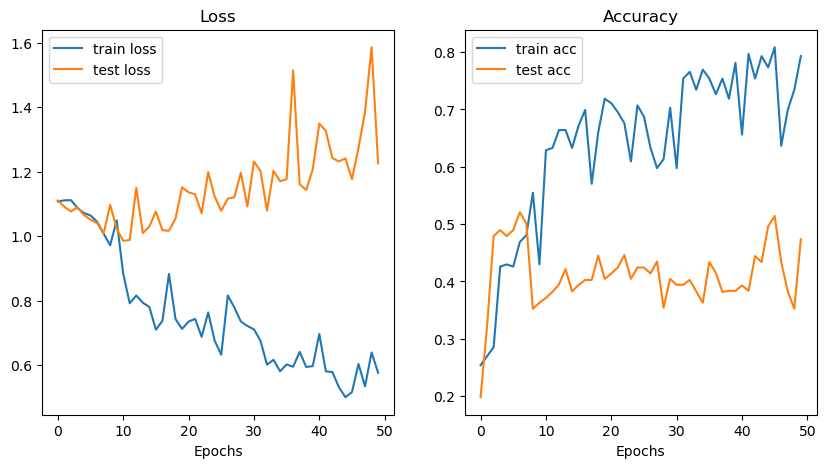

In [84]:
def plot_loss_curves(results):
    _, axs = plt.subplots(1, 2, figsize=(10, 5))
    epochs = list(range(len(results["train_loss"])))
    axs[0].plot(epochs, results["train_loss"], label="train loss")
    axs[0].plot(epochs, results["test_loss"], label="test loss")
    axs[1].plot(epochs, results["train_acc"], label="train acc")
    axs[1].plot(epochs, results["test_acc"], label="test acc")
    axs[0].legend()
    axs[0].set_title("Loss")
    axs[0].set_xlabel("Epochs")    
    axs[1].legend()    
    axs[1].set_title("Accuracy")
    axs[1].set_xlabel("Epochs")    

plot_loss_curves(model_result)


### 7. Model with data augmentation

In [85]:
import os
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

train_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.TrivialAugmentWide(),
    transforms.ToTensor()
])
test_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

train_dataset = Custom_dataset(train_dir,
                               train_transforms)
test_dataset = Custom_dataset(test_dir,
                              test_transforms)

train_dataloader = DataLoader(train_dataset,
                              batch_size=BATCH_SIZE,
                            #   num_workers=NUM_WORKERS,
                              shuffle=True)
test_dataloader = DataLoader(test_dataset,
                             batch_size=BATCH_SIZE,
                            #  num_workers=NUM_WORKERS,
                             shuffle=False)

In [88]:
model = TinyVGG(3, 10, len(train_dataset.classes)).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(params=model.parameters(), lr=0.001)
torch.manual_seed(42)
torch.cuda.manual_seed(42)
augmented_results = train(model, train_dataloader, test_dataloader, loss_fn, optimizer, device, EPOCH_NUM)

  0%|          | 0/50 [00:00<?, ?it/s]

----------Epoch0----------


  2%|▏         | 1/50 [00:01<01:08,  1.40s/it]

train loss: 1.1097 |train accuracy: 0.3008 |test loss: 1.0923 |test accuracy: 0.4792 |
----------Epoch1----------


  4%|▍         | 2/50 [00:02<00:59,  1.25s/it]

train loss: 1.0805 |train accuracy: 0.4531 |test loss: 1.1358 |test accuracy: 0.1979 |
----------Epoch2----------


  6%|▌         | 3/50 [00:03<00:55,  1.18s/it]

train loss: 1.1252 |train accuracy: 0.2930 |test loss: 1.1514 |test accuracy: 0.1979 |
----------Epoch3----------


  8%|▊         | 4/50 [00:04<00:52,  1.14s/it]

train loss: 1.0903 |train accuracy: 0.4141 |test loss: 1.1017 |test accuracy: 0.2794 |
----------Epoch4----------


 10%|█         | 5/50 [00:05<00:51,  1.14s/it]

train loss: 1.0902 |train accuracy: 0.3789 |test loss: 1.0998 |test accuracy: 0.3191 |
----------Epoch5----------


 12%|█▏        | 6/50 [00:07<00:50,  1.15s/it]

train loss: 1.1067 |train accuracy: 0.3086 |test loss: 1.0782 |test accuracy: 0.4792 |
----------Epoch6----------


 14%|█▍        | 7/50 [00:08<00:49,  1.15s/it]

train loss: 1.0882 |train accuracy: 0.4688 |test loss: 1.1028 |test accuracy: 0.2491 |
----------Epoch7----------


 16%|█▌        | 8/50 [00:09<00:48,  1.15s/it]

train loss: 1.0666 |train accuracy: 0.4141 |test loss: 1.1145 |test accuracy: 0.1979 |
----------Epoch8----------


 18%|█▊        | 9/50 [00:10<00:46,  1.14s/it]

train loss: 1.1019 |train accuracy: 0.2930 |test loss: 1.1109 |test accuracy: 0.1979 |
----------Epoch9----------


 20%|██        | 10/50 [00:11<00:45,  1.14s/it]

train loss: 1.0535 |train accuracy: 0.4414 |test loss: 1.0981 |test accuracy: 0.2604 |
----------Epoch10----------


 22%|██▏       | 11/50 [00:12<00:44,  1.15s/it]

train loss: 1.1273 |train accuracy: 0.3203 |test loss: 1.0928 |test accuracy: 0.2708 |
----------Epoch11----------


 24%|██▍       | 12/50 [00:13<00:43,  1.14s/it]

train loss: 1.0680 |train accuracy: 0.3828 |test loss: 1.0690 |test accuracy: 0.4650 |
----------Epoch12----------


 26%|██▌       | 13/50 [00:14<00:41,  1.13s/it]

train loss: 1.0111 |train accuracy: 0.5312 |test loss: 1.0650 |test accuracy: 0.4233 |
----------Epoch13----------


 28%|██▊       | 14/50 [00:16<00:40,  1.13s/it]

train loss: 1.0579 |train accuracy: 0.4102 |test loss: 1.0638 |test accuracy: 0.3920 |
----------Epoch14----------


 30%|███       | 15/50 [00:17<00:40,  1.14s/it]

train loss: 1.0093 |train accuracy: 0.4805 |test loss: 1.0042 |test accuracy: 0.4337 |
----------Epoch15----------


 32%|███▏      | 16/50 [00:18<00:38,  1.14s/it]

train loss: 1.0242 |train accuracy: 0.4492 |test loss: 0.9941 |test accuracy: 0.3116 |
----------Epoch16----------


 34%|███▍      | 17/50 [00:19<00:37,  1.13s/it]

train loss: 1.0147 |train accuracy: 0.4570 |test loss: 1.0684 |test accuracy: 0.4621 |
----------Epoch17----------


 36%|███▌      | 18/50 [00:20<00:36,  1.13s/it]

train loss: 1.0908 |train accuracy: 0.3359 |test loss: 1.0590 |test accuracy: 0.3835 |
----------Epoch18----------


 38%|███▊      | 19/50 [00:21<00:34,  1.12s/it]

train loss: 0.9862 |train accuracy: 0.4688 |test loss: 1.0301 |test accuracy: 0.3116 |
----------Epoch19----------


 40%|████      | 20/50 [00:22<00:34,  1.13s/it]

train loss: 0.9137 |train accuracy: 0.5664 |test loss: 1.0911 |test accuracy: 0.3428 |
----------Epoch20----------


 42%|████▏     | 21/50 [00:24<00:32,  1.13s/it]

train loss: 0.9505 |train accuracy: 0.5586 |test loss: 1.0954 |test accuracy: 0.3116 |
----------Epoch21----------


 44%|████▍     | 22/50 [00:25<00:31,  1.13s/it]

train loss: 0.8827 |train accuracy: 0.5664 |test loss: 1.1311 |test accuracy: 0.3324 |
----------Epoch22----------


 46%|████▌     | 23/50 [00:26<00:30,  1.12s/it]

train loss: 0.8302 |train accuracy: 0.5938 |test loss: 1.1475 |test accuracy: 0.3532 |
----------Epoch23----------


 48%|████▊     | 24/50 [00:27<00:28,  1.11s/it]

train loss: 0.8682 |train accuracy: 0.6172 |test loss: 1.0918 |test accuracy: 0.3513 |
----------Epoch24----------


 50%|█████     | 25/50 [00:28<00:27,  1.10s/it]

train loss: 1.0250 |train accuracy: 0.4727 |test loss: 1.0710 |test accuracy: 0.4034 |
----------Epoch25----------


 52%|█████▏    | 26/50 [00:29<00:26,  1.10s/it]

train loss: 0.8806 |train accuracy: 0.5859 |test loss: 1.0507 |test accuracy: 0.3428 |
----------Epoch26----------


 54%|█████▍    | 27/50 [00:30<00:25,  1.10s/it]

train loss: 0.8394 |train accuracy: 0.6289 |test loss: 1.1130 |test accuracy: 0.3845 |
----------Epoch27----------


 56%|█████▌    | 28/50 [00:31<00:24,  1.10s/it]

train loss: 0.9981 |train accuracy: 0.4375 |test loss: 1.0616 |test accuracy: 0.3731 |
----------Epoch28----------


 58%|█████▊    | 29/50 [00:32<00:22,  1.09s/it]

train loss: 0.9102 |train accuracy: 0.5273 |test loss: 1.0246 |test accuracy: 0.3731 |
----------Epoch29----------


 60%|██████    | 30/50 [00:33<00:21,  1.09s/it]

train loss: 0.8964 |train accuracy: 0.6484 |test loss: 1.0904 |test accuracy: 0.3532 |
----------Epoch30----------


 62%|██████▏   | 31/50 [00:35<00:21,  1.11s/it]

train loss: 0.9340 |train accuracy: 0.5977 |test loss: 1.0105 |test accuracy: 0.4223 |
----------Epoch31----------


 64%|██████▍   | 32/50 [00:36<00:19,  1.10s/it]

train loss: 0.8067 |train accuracy: 0.6523 |test loss: 0.9985 |test accuracy: 0.4527 |
----------Epoch32----------


 66%|██████▌   | 33/50 [00:37<00:18,  1.10s/it]

train loss: 0.8023 |train accuracy: 0.6523 |test loss: 1.0656 |test accuracy: 0.3314 |
----------Epoch33----------


 68%|██████▊   | 34/50 [00:38<00:17,  1.10s/it]

train loss: 0.8588 |train accuracy: 0.5391 |test loss: 1.0823 |test accuracy: 0.3835 |
----------Epoch34----------


 70%|███████   | 35/50 [00:39<00:16,  1.10s/it]

train loss: 0.8045 |train accuracy: 0.6406 |test loss: 1.1062 |test accuracy: 0.3835 |
----------Epoch35----------


 72%|███████▏  | 36/50 [00:40<00:15,  1.10s/it]

train loss: 0.7993 |train accuracy: 0.6406 |test loss: 1.0341 |test accuracy: 0.4441 |
----------Epoch36----------


 74%|███████▍  | 37/50 [00:41<00:14,  1.10s/it]

train loss: 0.9114 |train accuracy: 0.4922 |test loss: 1.0693 |test accuracy: 0.3939 |
----------Epoch37----------


 76%|███████▌  | 38/50 [00:42<00:13,  1.09s/it]

train loss: 0.8981 |train accuracy: 0.5625 |test loss: 1.0046 |test accuracy: 0.4441 |
----------Epoch38----------


 78%|███████▊  | 39/50 [00:43<00:12,  1.09s/it]

train loss: 0.8099 |train accuracy: 0.6680 |test loss: 1.0774 |test accuracy: 0.4347 |
----------Epoch39----------


 80%|████████  | 40/50 [00:44<00:10,  1.09s/it]

train loss: 0.8921 |train accuracy: 0.5195 |test loss: 1.0425 |test accuracy: 0.4536 |
----------Epoch40----------


 82%|████████▏ | 41/50 [00:45<00:09,  1.09s/it]

train loss: 0.7518 |train accuracy: 0.6875 |test loss: 1.1126 |test accuracy: 0.4318 |
----------Epoch41----------


 84%|████████▍ | 42/50 [00:47<00:08,  1.09s/it]

train loss: 0.9024 |train accuracy: 0.5664 |test loss: 1.0272 |test accuracy: 0.4943 |
----------Epoch42----------


 86%|████████▌ | 43/50 [00:48<00:07,  1.09s/it]

train loss: 0.7120 |train accuracy: 0.7109 |test loss: 1.0468 |test accuracy: 0.3816 |
----------Epoch43----------


 88%|████████▊ | 44/50 [00:49<00:06,  1.10s/it]

train loss: 0.7859 |train accuracy: 0.6914 |test loss: 1.0123 |test accuracy: 0.4129 |
----------Epoch44----------


 90%|█████████ | 45/50 [00:50<00:05,  1.10s/it]

train loss: 0.7404 |train accuracy: 0.6641 |test loss: 1.0450 |test accuracy: 0.3627 |
----------Epoch45----------


 92%|█████████▏| 46/50 [00:51<00:04,  1.10s/it]

train loss: 0.7605 |train accuracy: 0.6758 |test loss: 1.0206 |test accuracy: 0.4422 |
----------Epoch46----------


 94%|█████████▍| 47/50 [00:52<00:03,  1.10s/it]

train loss: 0.8625 |train accuracy: 0.6211 |test loss: 1.0196 |test accuracy: 0.4631 |
----------Epoch47----------


 96%|█████████▌| 48/50 [00:53<00:02,  1.10s/it]

train loss: 0.8970 |train accuracy: 0.5312 |test loss: 1.0447 |test accuracy: 0.3617 |
----------Epoch48----------


 98%|█████████▊| 49/50 [00:54<00:01,  1.10s/it]

train loss: 0.8141 |train accuracy: 0.6523 |test loss: 1.0252 |test accuracy: 0.3722 |
----------Epoch49----------


100%|██████████| 50/50 [00:55<00:00,  1.12s/it]

train loss: 0.9962 |train accuracy: 0.5234 |test loss: 1.0285 |test accuracy: 0.4744 |


dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc'])


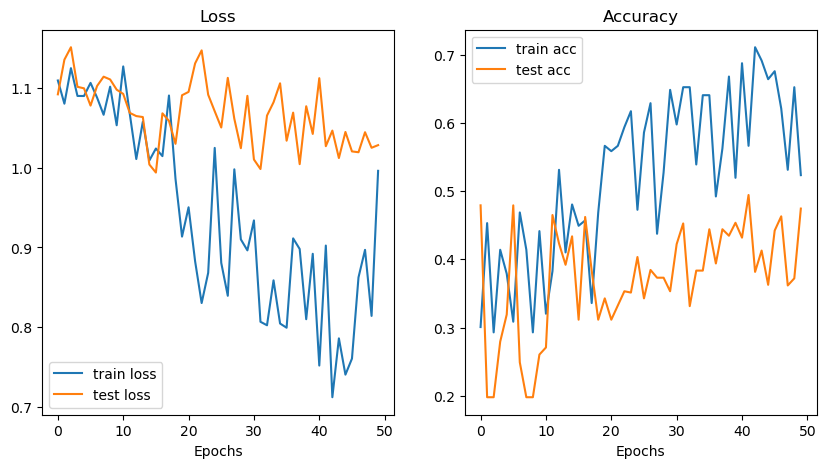

In [90]:
plot_loss_curves(augmented_results)
print(augmented_results.keys())

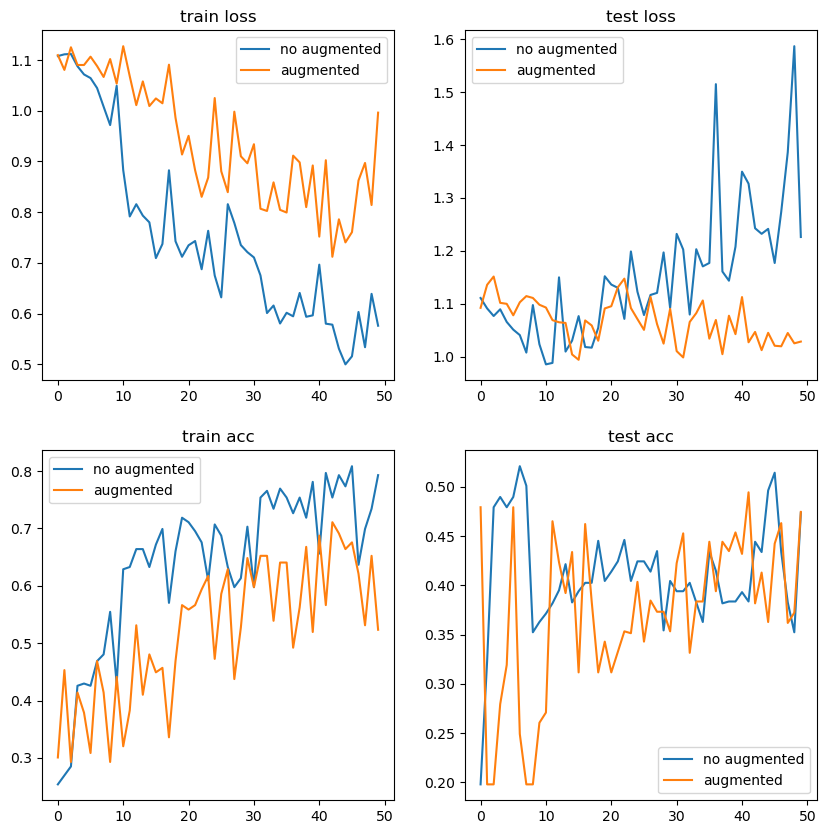

In [93]:
_, axs = plt.subplots(2, 2, figsize=(10, 10))
axs[0, 0].plot(range(EPOCH_NUM), model_result["train_loss"], label="no augmented")
axs[0, 0].plot(range(EPOCH_NUM), augmented_results["train_loss"], label="augmented")
axs[0, 0].set_title("train loss")
axs[0, 1].plot(range(EPOCH_NUM), model_result["test_loss"], label="no augmented")
axs[0, 1].plot(range(EPOCH_NUM), augmented_results["test_loss"], label="augmented")
axs[0, 1].set_title("test loss")
axs[1, 0].plot(range(EPOCH_NUM), model_result["train_acc"], label="no augmented")
axs[1, 0].plot(range(EPOCH_NUM), augmented_results["train_acc"], label="augmented")
axs[1, 0].set_title("train acc")
axs[1, 1].plot(range(EPOCH_NUM), model_result["test_acc"], label="no augmented")
axs[1, 1].plot(range(EPOCH_NUM), augmented_results["test_acc"], label="augmented")
axs[1, 1].set_title("test acc")
axs[0, 0].legend()
axs[1, 0].legend()
axs[1, 1].legend()
axs[0, 1].legend()